# Imports


In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import os
os.environ['WANDB_DISABLED'] = 'true'
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
os.environ["HF_HOME"] = "./.huggingface"
os.environ["HF_TOKEN"] = "./HF_token"

In [3]:
import numpy as np
from numba import cuda
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
from datasets import Dataset, DatasetDict, Features, Value, ClassLabel
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BitsAndBytesConfig, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model

# Load Datasets
*   Code switched and monolingual cantonese datasets are loaded.


In [4]:
code_switched_df = pd.read_csv('./MCE_data.csv')
code_switched_df['label'] = code_switched_df['label'].replace({1: 'Negative', 2: 'Neutral', 3: 'Positive'})

features = Features({
    'text': Value('string'),
    'label': ClassLabel(num_classes=3, names=['Negative', 'Neutral', 'Positive'])
})

cs_dataset = Dataset.from_pandas(code_switched_df)
cs_dataset = cs_dataset.cast(features)

print(cs_dataset[:10])

def categorize_label(score):
    if score <= '2':
        return "Negative"
    elif score == '3':
        return "Neutral"
    else:
        return "Positive"

with open('./Openrice_Cantonese.txt', "r") as file:
    data_from_file = file.readlines()

parsed_data = [row.split("\t\t", 1) for row in data_from_file]

canto_df = pd.DataFrame(parsed_data, columns=["rating", "text"])

canto_df['label'] = canto_df['rating'].apply(categorize_label)

canto_df = canto_df.drop(columns=['rating'])

canto_dataset = Dataset.from_pandas(canto_df)
canto_dataset = canto_dataset.cast(features)
canto_dataset[0:5]

Casting the dataset:   0%|          | 0/1154 [00:00<?, ? examples/s]

{'text': ['"你知唔知今日嘅temperature會落到低至10度，一定要著厚d嘅clothes啊！"', '"我check咗天氣app，佢話今日會有thunderstorm，最好唔好去戶外行嘅。"', '"飛機已經被grounded喇，因為typhoon signal已經升到No.8嚟啦。"', '"周圍都有well-developed霧，嚴重limit我哋嘅visibility，開車嘅時候要小心啲！"', '"Forecast話晚上嘅weather會變得好cold，會降到freezing point，甚至可能會有snow喎。"', '"感覺到今晚嘅breeze都好舒服，temperature剛剛好，真係一個perfect night去郊遊。"', '"你有冇見過咁震撼嘅sunset? 天氣真係好perfect，可以坐下嚟慢慢欣賞。" ', '"睇嚟weekend嘅weather會比較unstable，可能會有rain shower，最好做好準備。"', '"地鐵公告話因為暴雨嚟襲，好多routes都被flooded，需要改行其他routes返屋企。"', '"咁嘅Humidity真係令人好難受，幸好有air conditioning可以調節。"'], 'label': [1, 1, 1, 1, 1, 2, 2, 1, 1, 0]}


Casting the dataset:   0%|          | 0/61610 [00:00<?, ? examples/s]

{'text': ['雖然貴💸但真心好食嘅爆汁牛肉餅💦<sssss>九龍城除咗泰國菜出名外，仲有呢間「清真牛肉館」🏠佢地最出名嘅就係呢個牛肉餅，細細一件已經要$18，價錢確實有啲貴，但味道真係唔錯👍🏻<sssss><sssss>外皮煎得好香脆，一咬落去，啲湯汁噴晒出嚟💦如果無經驗者，真係超容易整污糟件衫😝(其實我差少少都中招，好彩身手敏捷😂😂避開咗！）另外佢肉味香濃，口感飽滿！以牛肉餅呢講，佢都算一哥🏅如果佢係旺區開分店就好啦！咁就唔洗吓吓碌入九龍城先食到\n',
  '九龍城對我黎講，絕對唔係一個就腳既地方一年可能只會經過幾次但每次經過，我都會諗起牛肉餅<sssss>記得第一次食已經係10年前既事10年後今日，水準依然保持皮既厚度適中，可以將牛肉汁緊緊鎖住但又唔一口粉一啖咬落去，熱辣辣既肉汁真係會爆出黎所以真係要小心燙口入面既牛勁香勁好味真係返到屋企，諗返起都流口水\n',
  '九龍城，不只是泰國菜出名，還有不少地道特色的餐館都非常有名氣，人人都爭著朝聖。其中一間連名人都朝的菜館，必定有這裡的份。而我今次第一次入九龍城，當然不會錯過它。<sssss>點了一份招牌牛肉餅，說真的還真夠貴的，但那焦香的表皮同香氣的濃郁，它對得起這個價錢 ! 先咬一口試個究竟。<sssss>一咬開真是不得了，牛肉汁流到一碟也是。好不容易用那包子盛起汁液。熱辣辣的湯汁惹味非常，整個肉涵都充滿著濃郁的味道。加上它脆脆的表皮，甘香可口。不消十分鐘，兩塊厚厚牛肉餅清掉，它不愧是九龍城中必朝的聖地\n',
  '<sssss>同事買咗九龍城嘅牛肉餅返公司一齊食，返到嚟都仲係暖嘅！<sssss>雖然牛肉餅仲係暖，不過因為外賣嘅關係都焗咗一陣，所以個皮唔夠香脆！腍咗少少！<sssss>咬開入面D牛肉汁就滴出嚟，仲聞到好香牛肉味！好多汁、好香！牛肉亦鮮嫩多汁、味道濃郁！\n',
  '平日下午12:30左右去到，都爆滿，記得book位。5個人點了幾個菜share。<sssss>牛肉餅，好鎖住d肉汁，不過個皮乾左Ｄ，好好味。<sssss>牛肉餃，一碟10個，一口食晒，Ｄ肉都好鮮嫩！值得一試。<sssss>麻醬雞絲麵，麻醬味好重，條條麵都有麻醬味！！(冷食)<sssss>如果你食羊既，一定要食咖哩羊腩！羊肉唔SO，連Ｄ咖哩汁都有羊味！！好好吃！<sssss>5個人SHARE，每人$50,好飽，黎九龍城一定

# NLLB-LLM2Vec (Pre-trained)

In [ ]:
import zipfile

# Path to the zip file
zip_file_path = "./en-NLLB-LLM2Vec.zip"

# Directory to extract the contents
extract_to = "./en-NLLB-LLM2Vec"

# Create the extraction directory if it doesn't exist
import os
if not os.path.exists(extract_to):
    os.makedirs(extract_to)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Files extracted to: {extract_to}")

# Load the fine-tuned model and tokenizer
model_name = "./en-NLLB-LLM2Vec"  # Path to the fine-tuned model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name,  num_labels=3, trust_remote_code=True)

# Move the model to the GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Ensure the model is in evaluation mode
model.eval()


tokenizer = AutoTokenizer.from_pretrained(model_name, src_lang="yue_Hant")
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=256)

Files extracted to: ./en-NLLB-LLM2Vec


config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

configuration_nllbllm2vec.py:   0%|          | 0.00/3.03k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/fdschmidt93/NLLB-LLM2Vec-Meta-Llama-31-8B-Instruct-mntp-unsup-simcse:
- configuration_nllbllm2vec.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_nllbllm2vec.py:   0%|          | 0.00/22.4k [00:00<?, ?B/s]

modeling_llama_encoder.py:   0%|          | 0.00/7.44k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/fdschmidt93/NLLB-LLM2Vec-Meta-Llama-31-8B-Instruct-mntp-unsup-simcse:
- modeling_llama_encoder.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/fdschmidt93/NLLB-LLM2Vec-Meta-Llama-31-8B-Instruct-mntp-unsup-simcse:
- modeling_nllbllm2vec.py
- modeling_llama_encoder.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/41.2k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/998M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of NLLBLLM2VecForSequenceClassification were not initialized from the model checkpoint at fdschmidt93/NLLB-LLM2Vec-Meta-Llama-31-8B-Instruct-mntp-unsup-simcse and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import math
# Tokenize the dataset
tokenized_dataset = cs_dataset.map(preprocess_function, batched=True)
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
nan_count = sum(math.isnan(x) for x in tokenized_dataset['label'] if x is not None)

print(f"Number of NaN labels: {nan_count}")
print(f"Contains NaN labels: {nan_count > 0}")
tokenized_dataset

Map:   0%|          | 0/1154 [00:00<?, ? examples/s]

Number of NaN labels: 0
Contains NaN labels: False


Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 1154
})

In [ ]:
from torch.utils.data import DataLoader

batch_size = 16
dataloader = DataLoader(tokenized_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
predictions = []

with torch.no_grad():
    for batch in dataloader:
        input_ids = batch["input_ids"].to(model.device)
        attention_mask = batch["attention_mask"].to(model.device)

        # Forward pass through the model
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Get predicted class indices
        batch_predictions = torch.argmax(logits, dim=-1).cpu().numpy()
        predictions.extend(batch_predictions)


In [ ]:
# Compute metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

labels = tokenized_dataset['label']
accuracy = accuracy_score(labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(
    labels, predictions, average='weighted'
)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


Accuracy: 0.7772963604852686
Precision: 0.7820233977659168
Recall: 0.7772963604852686
F1-score: 0.7654680636733309


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the classification report
report = classification_report(labels, predictions, target_names=["Negative", "Neutral", "Positive"])

# Print the classification report
print(report)

              precision    recall  f1-score   support

    Negative       0.81      0.94      0.87       388
     Neutral       0.81      0.51      0.63       374
    Positive       0.73      0.86      0.79       392

    accuracy                           0.78      1154
   macro avg       0.78      0.77      0.76      1154
weighted avg       0.78      0.78      0.77      1154



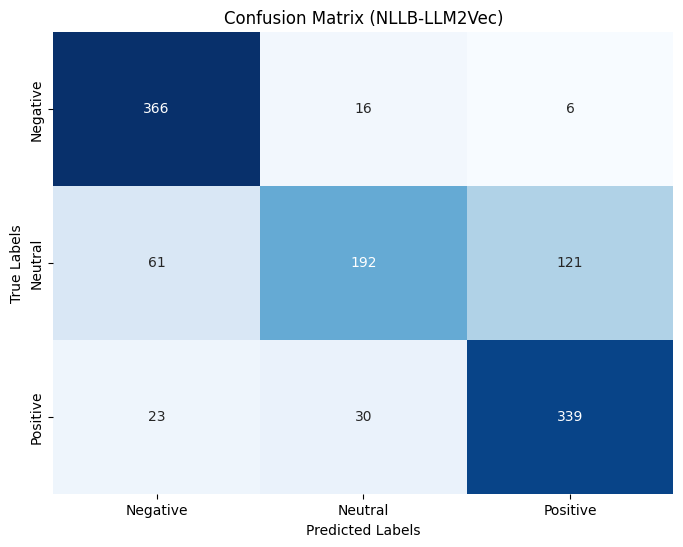

In [ ]:
# Plot the confusion matrix as a heatmap

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the confusion matrix
conf_matrix = confusion_matrix(labels, predictions)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (NLLB-LLM2Vec)")
plt.show()

# NLLB-LLM2Vec (Fine-tuned with Monolingual Data)

*   Fine-tuned on monolingual Cantonese data
*   Evaluate on code-switched Canto-Eng data

In [ ]:
model_name = "fdschmidt93/NLLB-LLM2Vec-Meta-Llama-31-8B-Instruct-mntp-unsup-simcse"
tokenizer = AutoTokenizer.from_pretrained(model_name, src_lang="yue_Hant") # change the source language accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=256)

In [ ]:
train_dataset = canto_dataset.shuffle(seed=42).select(range(15000)).map(preprocess_function, batched=True)
test_dataset = cs_dataset.map(preprocess_function, batched=True)

print(train_dataset)
print(test_dataset)

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1154 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 15000
})
Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 1154
})


In [ ]:
from peft.tuners.lora.config import LoraConfig

# Adjust LoRA settings for sentiment analysis
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=r".*llm2vec.*(self_attn\.(q|k|v|o)_proj|mlp\.(gate|up|down)_proj).*",
    bias="none",
    task_type="SEQ_CLS"
)

# Load model and apply LoRA
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,  # Sentiment analysis has three classes
    trust_remote_code=True,
    torch_dtype=torch.bfloat16,
)
model = get_peft_model(model, lora_config)
model.to(device)

config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

configuration_nllbllm2vec.py:   0%|          | 0.00/3.03k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/fdschmidt93/NLLB-LLM2Vec-Meta-Llama-31-8B-Instruct-mntp-unsup-simcse:
- configuration_nllbllm2vec.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_nllbllm2vec.py:   0%|          | 0.00/22.4k [00:00<?, ?B/s]

modeling_llama_encoder.py:   0%|          | 0.00/7.44k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/fdschmidt93/NLLB-LLM2Vec-Meta-Llama-31-8B-Instruct-mntp-unsup-simcse:
- modeling_llama_encoder.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/fdschmidt93/NLLB-LLM2Vec-Meta-Llama-31-8B-Instruct-mntp-unsup-simcse:
- modeling_nllbllm2vec.py
- modeling_llama_encoder.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/41.2k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/998M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of NLLBLLM2VecForSequenceClassification were not initialized from the model checkpoint at fdschmidt93/NLLB-LLM2Vec-Meta-Llama-31-8B-Instruct-mntp-unsup-simcse and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): NLLBLLM2VecForSequenceClassification(
      (model): NLLBLLM2Vec(
        (nllb_encoder): M2M100Encoder(
          (embed_tokens): M2M100ScaledWordEmbedding(256206, 1024, padding_idx=1)
          (embed_positions): M2M100SinusoidalPositionalEmbedding()
          (layers): ModuleList(
            (0-11): 12 x M2M100EncoderLayer(
              (self_attn): M2M100SdpaAttention(
                (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
              )
              (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
              (activation_fn): ReLU()
              (fc1): Linear(in_features=1024, out_features=4096, bias=Tru

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Ensure predictions are converted from logits to class indices
    if isinstance(predictions, tuple):
        predictions = predictions[0]  # Extract logits


    predictions = predictions.argmax(axis=1)  # Get predicted class index
    labels = labels.astype(int)

    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}

In [ ]:
training_args = TrainingArguments(
    output_dir="./sentiment_model",
    num_train_epochs=3,
    # weight_decay=0.01,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=4,
    # warmup_steps=500,
    # eval_strategy="epoch",
    # save_strategy="epoch",
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=500,  # Evaluate every 500 steps
    save_steps=500,  # Save model every 500 steps
    learning_rate=5e-5,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    report_to='none',  # Disable logging to all integrations
    logging_dir="./logs",
    logging_steps=500,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
torch.cuda.empty_cache()
trainer.train()

trainer.save_model("./fine_tuned_NLLB-LLM2Vec")
tokenizer.save_pretrained("./fine_tuned_NLLB-LLM2Vec")

Step,Training Loss,Validation Loss,Accuracy
500,0.698600,0.817754,0.580589
1000,0.580300,0.896663,0.537262
1500,0.534400,0.861474,0.569324
2000,0.502500,0.912029,0.553726
2500,0.454700,0.877872,0.569324


('./fine_tuned_NLLB-LLM2Vec/tokenizer_config.json',
 './fine_tuned_NLLB-LLM2Vec/special_tokens_map.json',
 './fine_tuned_NLLB-LLM2Vec/sentencepiece.bpe.model',
 './fine_tuned_NLLB-LLM2Vec/added_tokens.json',
 './fine_tuned_NLLB-LLM2Vec/tokenizer.json')

In [ ]:
prediction_output = trainer.predict(test_dataset)

predictions = prediction_output.predictions
labels = prediction_output.label_ids

In [ ]:
# Step 4: Extract the correct tensor from the tuple
predictions = predictions[0]  # Assuming the first element contains the logits or predictions
# Step 5: Convert logits to class predictions if necessary
if len(predictions.shape) == 2:  # Assuming logits are 2-dimensional
    predictions = np.argmax(predictions, axis=1)

# Step 6: Verify shapes
print("Labels shape:", labels.shape)
print("Predictions shape:", predictions.shape)

# Compute metrics

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

accuracy = accuracy_score(labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(
    labels, predictions, average='weighted'
)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


Labels shape: (1154,)
Predictions shape: (1154,)
Accuracy: 0.5805892547660312
Precision: 0.6287984348921845
Recall: 0.5805892547660312
F1-score: 0.5554063424646104


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the classification report
report = classification_report(labels, predictions, target_names=["Negative", "Neutral", "Positive"])

# Print the classification report
print(report)

              precision    recall  f1-score   support

    Negative       0.95      0.53      0.68       388
     Neutral       0.40      0.24      0.30       374
    Positive       0.53      0.96      0.68       392

    accuracy                           0.58      1154
   macro avg       0.63      0.58      0.55      1154
weighted avg       0.63      0.58      0.56      1154



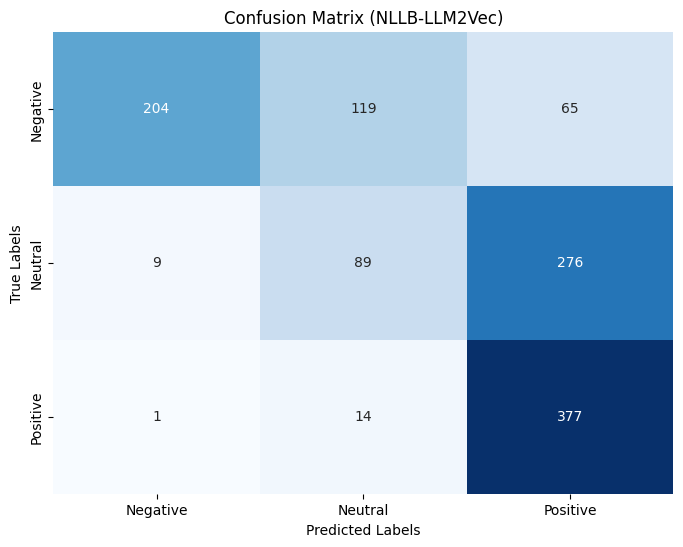

In [ ]:
# Plot the confusion matrix as a heatmap

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the confusion matrix
conf_matrix = confusion_matrix(labels, predictions)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (NLLB-LLM2Vec)")
plt.show()

# NLLB-LLM2Vec (Fine-tuned with Code-switched Data)

*   Train-test split on code-switched dataset


In [ ]:
model_name = "fdschmidt93/NLLB-LLM2Vec-Meta-Llama-31-8B-Instruct-mntp-unsup-simcse"
tokenizer = AutoTokenizer.from_pretrained(model_name, src_lang="yue_Hant") # change the source language accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=256)
tokenized_dataset = cs_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/1154 [00:00<?, ? examples/s]

In [ ]:
train_test_split = tokenized_dataset.train_test_split(test_size=0.2, stratify_by_column='label', seed=42)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

In [ ]:
from peft.tuners.lora.config import LoraConfig

# Adjust LoRA settings for sentiment analysis
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=r".*llm2vec.*(self_attn\.(q|k|v|o)_proj|mlp\.(gate|up|down)_proj).*",
    bias="none",
    task_type="SEQ_CLS"
)

# Load model and apply LoRA
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,  # Sentiment analysis has three classes
    trust_remote_code=True,
    torch_dtype=torch.bfloat16,
)
model = get_peft_model(model, lora_config)
model.to(device)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of NLLBLLM2VecForSequenceClassification were not initialized from the model checkpoint at fdschmidt93/NLLB-LLM2Vec-Meta-Llama-31-8B-Instruct-mntp-unsup-simcse and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): NLLBLLM2VecForSequenceClassification(
      (model): NLLBLLM2Vec(
        (nllb_encoder): M2M100Encoder(
          (embed_tokens): M2M100ScaledWordEmbedding(256206, 1024, padding_idx=1)
          (embed_positions): M2M100SinusoidalPositionalEmbedding()
          (layers): ModuleList(
            (0-11): 12 x M2M100EncoderLayer(
              (self_attn): M2M100SdpaAttention(
                (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
              )
              (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
              (activation_fn): ReLU()
              (fc1): Linear(in_features=1024, out_features=4096, bias=Tru

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Ensure predictions are converted from logits to class indices
    if isinstance(predictions, tuple):
        predictions = predictions[0]  # Extract logits


    predictions = predictions.argmax(axis=1)  # Get predicted class index
    labels = labels.astype(int)

    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}

In [ ]:
training_args = TrainingArguments(
    output_dir="./sentiment_model",
    num_train_epochs=3,
    # weight_decay=0.01,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=4,
    # warmup_steps=500,
    # eval_strategy="epoch",
    # save_strategy="epoch",
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=500,  # Evaluate every 500 steps
    save_steps=500,  # Save model every 500 steps
    learning_rate=5e-5,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    report_to='none',  # Disable logging to all integrations
    logging_dir="./logs",
    logging_steps=500,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
torch.cuda.empty_cache()
trainer.train()

trainer.save_model("./fine_tuned_NLLB-LLM2Vec-cs")
tokenizer.save_pretrained("./fine_tuned_NLLB-LLM2Vec-cs")

Step,Training Loss,Validation Loss


('./fine_tuned_NLLB-LLM2Vec-cs/tokenizer_config.json',
 './fine_tuned_NLLB-LLM2Vec-cs/special_tokens_map.json',
 './fine_tuned_NLLB-LLM2Vec-cs/sentencepiece.bpe.model',
 './fine_tuned_NLLB-LLM2Vec-cs/added_tokens.json',
 './fine_tuned_NLLB-LLM2Vec-cs/tokenizer.json')

In [ ]:
prediction_output = trainer.predict(test_dataset)

predictions = prediction_output.predictions
labels = prediction_output.label_ids

In [ ]:
# Step 4: Extract the correct tensor from the tuple
predictions = predictions[0]  # Assuming the first element contains the logits or predictions

# Step 5: Convert logits to class predictions if necessary
if len(predictions.shape) == 2:  # Assuming logits are 2-dimensional
    predictions = np.argmax(predictions, axis=1)

# Step 6: Verify shapes
print("Labels shape:", labels.shape)
print("Predictions shape:", predictions.shape)

# Compute metrics

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

accuracy = accuracy_score(labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(
    labels, predictions, average='weighted'
)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


Labels shape: (231,)
Predictions shape: (231,)
Accuracy: 0.9004329004329005
Precision: 0.9007011947995015
Recall: 0.9004329004329005
F1-score: 0.9005415925078962


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the classification report
report = classification_report(labels, predictions, target_names=["Negative", "Neutral", "Positive"])

# Print the classification report
print(report)

              precision    recall  f1-score   support

    Negative       0.95      0.94      0.94        78
     Neutral       0.87      0.87      0.87        75
    Positive       0.89      0.90      0.89        78

    accuracy                           0.90       231
   macro avg       0.90      0.90      0.90       231
weighted avg       0.90      0.90      0.90       231



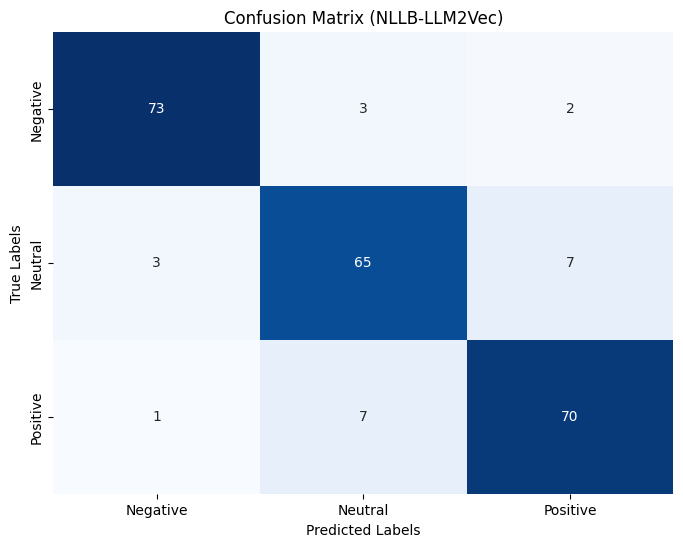

In [ ]:
# Plot the confusion matrix as a heatmap

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the confusion matrix
conf_matrix = confusion_matrix(labels, predictions)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (NLLB-LLM2Vec)")
plt.show()

# XLMR-SM (Pre-trained)

In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

In [6]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=512)

# Tokenize the dataset
tokenized_dataset = cs_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/1154 [00:00<?, ? examples/s]

In [7]:
from torch.utils.data import DataLoader

# Convert the tokenized test dataset to PyTorch tensors
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Create a DataLoader for the test dataset
test_dataloader = DataLoader(tokenized_dataset, batch_size=16)

In [8]:
# Move the model to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Ensure the model is in evaluation mode
model.eval()

# Lists to store predictions and true labels
all_predictions = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for batch in test_dataloader:
        # Move inputs and labels to the GPU
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Pass the inputs through the model
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Get the logits (raw model outputs)
        logits = outputs.logits

        # Convert logits to class predictions using argmax
        predictions = torch.argmax(logits, dim=1)

        # Append predictions and labels to the lists (move back to CPU if needed)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())



In [13]:
# Compute metrics

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

labels = tokenized_dataset['label']
accuracy = accuracy_score(all_labels, all_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_predictions, average='weighted'
)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the classification report
report = classification_report(labels, all_predictions, target_names=["Negative", "Neutral", "Positive"])

# Print the classification report
print(report)



Accuracy: 0.817157712305026
Precision: 0.8152198068306168
Recall: 0.817157712305026
F1-score: 0.8142461953412669
              precision    recall  f1-score   support

    Negative       0.87      0.91      0.89       388
     Neutral       0.78      0.67      0.72       374
    Positive       0.80      0.86      0.83       392

    accuracy                           0.82      1154
   macro avg       0.81      0.82      0.81      1154
weighted avg       0.82      0.82      0.81      1154



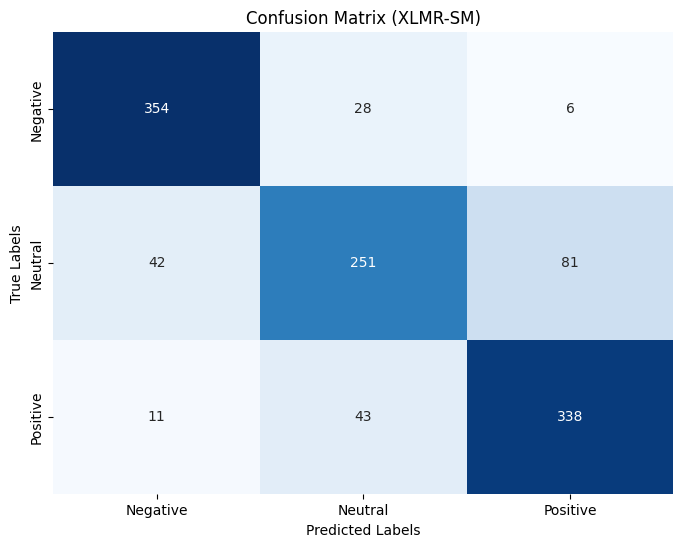

In [14]:
# Plot the confusion matrix as a heatmap

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the confusion matrix
conf_matrix = confusion_matrix(labels, all_predictions)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (XLMR-SM)")
plt.show()

# XLMR-SM (Fine-tuned with Monolingual Data)

In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

In [6]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=256)

In [7]:
train_dataset = canto_dataset.shuffle(seed=42).select(range(15000)).map(preprocess_function, batched=True)
test_dataset = cs_dataset.map(preprocess_function, batched=True)

print(train_dataset)
print(test_dataset)

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1154 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 15000
})
Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 1154
})


In [8]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Ensure predictions are converted from logits to class indices
    if isinstance(predictions, tuple):
        predictions = predictions[0]  # Extract logits


    predictions = predictions.argmax(axis=1)  # Get predicted class index
    labels = labels.astype(int)

    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}

In [9]:
# Define the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,  # Enable mixed precision training for faster training
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Fine-tune the model
trainer.train()

# Save the fine-tuned model
trainer.save_model("./fine_tuned_XLMR-SM")
tokenizer.save_pretrained("./fine_tuned_XLMR-SM")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-9-7f0f08a512e3>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.711100,0.752024,0.635182
2,0.559100,0.780265,0.639515
3,0.488700,0.775878,0.649913


('./fine_tuned_XLMR-SM/tokenizer_config.json',
 './fine_tuned_XLMR-SM/special_tokens_map.json',
 './fine_tuned_XLMR-SM/sentencepiece.bpe.model',
 './fine_tuned_XLMR-SM/added_tokens.json',
 './fine_tuned_XLMR-SM/tokenizer.json')

In [10]:
# Step 1: Perform prediction
prediction_output = trainer.predict(test_dataset)

# Step 2: Access predictions and true labels
predictions = prediction_output.predictions
labels = prediction_output.label_ids

In [11]:
# Step 5: Convert logits to class predictions if necessary
if len(predictions.shape) == 2:  # Assuming logits are 2-dimensional
    predictions = np.argmax(predictions, axis=1)

# Step 6: Verify shapes
print("Labels shape:", labels.shape)
print("Predictions shape:", predictions.shape)

# Step 7: Compute metrics
accuracy = accuracy_score(labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(
    labels, predictions, average='weighted'
)

# Step 8: Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the classification report
report = classification_report(labels, predictions, target_names=["Negative", "Neutral", "Positive"])

# Print the classification report
print(report)


Labels shape: (1154,)
Predictions shape: (1154,)
Accuracy: 0.6499133448873483
Precision: 0.6840090561168115
Recall: 0.6499133448873483
F1-score: 0.637967326783571
              precision    recall  f1-score   support

    Negative       0.97      0.64      0.77       388
     Neutral       0.48      0.35      0.40       374
    Positive       0.59      0.95      0.73       392

    accuracy                           0.65      1154
   macro avg       0.68      0.65      0.63      1154
weighted avg       0.68      0.65      0.64      1154



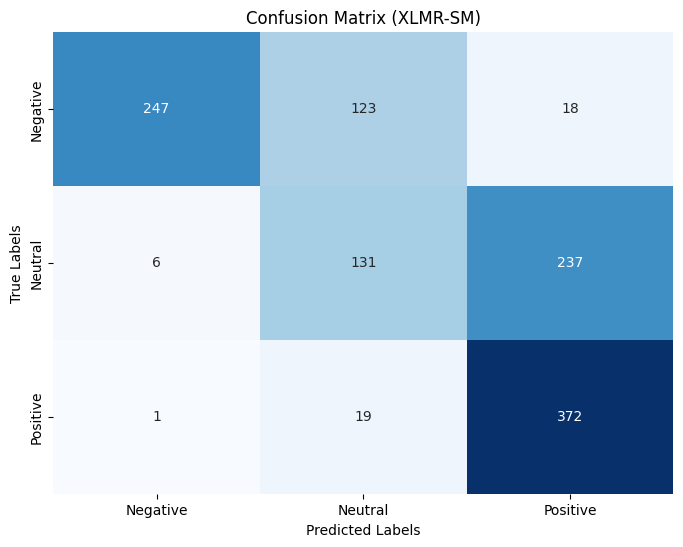

In [12]:
# Plot the confusion matrix as a heatmap

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the confusion matrix
conf_matrix = confusion_matrix(labels, predictions)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (XLMR-SM)")
plt.show()

# XLMR-SM (Fine-tuned with Code-switched Data)



In [13]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [14]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=256)
tokenized_dataset = cs_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/1154 [00:00<?, ? examples/s]

In [15]:
train_test_split = tokenized_dataset.train_test_split(test_size=0.2, stratify_by_column='label', seed=42)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

In [16]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Ensure predictions are converted from logits to class indices
    if isinstance(predictions, tuple):
        predictions = predictions[0]  # Extract logits


    predictions = predictions.argmax(axis=1)  # Get predicted class index
    labels = labels.astype(int)

    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}

In [17]:
# Define the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,  # Enable mixed precision training for faster training
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Fine-tune the model
trainer.train()

# Save the fine-tuned model
trainer.save_model("./fine_tuned_XLMR-SM-cs")
tokenizer.save_pretrained("./fine_tuned_XLMR-SM-cs")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-17-e9871e588132>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.442491,0.870130
2,No log,0.375430,0.887446
3,No log,0.401815,0.883117


('./fine_tuned_XLMR-SM-cs/tokenizer_config.json',
 './fine_tuned_XLMR-SM-cs/special_tokens_map.json',
 './fine_tuned_XLMR-SM-cs/sentencepiece.bpe.model',
 './fine_tuned_XLMR-SM-cs/added_tokens.json',
 './fine_tuned_XLMR-SM-cs/tokenizer.json')

In [18]:
# Step 1: Perform prediction
prediction_output = trainer.predict(test_dataset)

# Step 2: Access predictions and true labels
predictions = prediction_output.predictions
labels = prediction_output.label_ids

In [19]:
# Step 5: Convert logits to class predictions if necessary
if len(predictions.shape) == 2:  # Assuming logits are 2-dimensional
    predictions = np.argmax(predictions, axis=1)

# Step 6: Verify shapes
print("Labels shape:", labels.shape)
print("Predictions shape:", predictions.shape)

# Step 7: Compute metrics
accuracy = accuracy_score(labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(
    labels, predictions, average='weighted'
)

# Step 8: Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the classification report
report = classification_report(labels, predictions, target_names=["Negative", "Neutral", "Positive"])

# Print the classification report
print(report)


Labels shape: (231,)
Predictions shape: (231,)
Accuracy: 0.8874458874458875
Precision: 0.8871896719997986
Recall: 0.8874458874458875
F1-score: 0.8872924764003292
              precision    recall  f1-score   support

    Negative       0.92      0.94      0.93        78
     Neutral       0.86      0.85      0.86        75
    Positive       0.87      0.87      0.87        78

    accuracy                           0.89       231
   macro avg       0.89      0.89      0.89       231
weighted avg       0.89      0.89      0.89       231



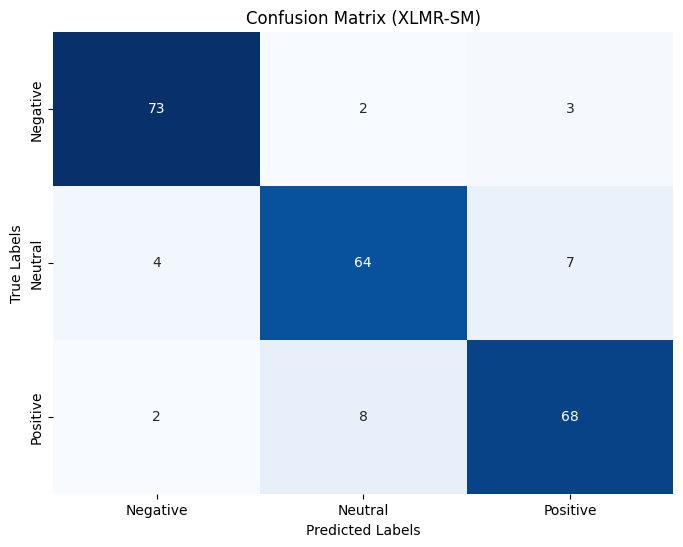

In [20]:
# Plot the confusion matrix as a heatmap

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the confusion matrix
conf_matrix = confusion_matrix(labels, predictions)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (XLMR-SM)")
plt.show()

# Erlangshen-RoBERTa-110M-Sentiment (Pre-trained)

In [21]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_name = "IDEA-CCNL/Erlangshen-RoBERTa-110M-Sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name, src_lang="yue_Hant")
model = AutoModelForSequenceClassification.from_pretrained(model_name)

config.json:   0%|          | 0.00/785 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/409M [00:00<?, ?B/s]

In [22]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=512)

# Tokenize the dataset
filtered_dataset = cs_dataset.filter(lambda example: example['label'] in [0, 2]).map(
    lambda example: {'label': 1 if example['label'] == 2 else example['label']}
)

tokenized_dataset = filtered_dataset.map(preprocess_function, batched=True)


Filter:   0%|          | 0/1154 [00:00<?, ? examples/s]

Map:   0%|          | 0/780 [00:00<?, ? examples/s]

Map:   0%|          | 0/780 [00:00<?, ? examples/s]

In [23]:
from torch.utils.data import DataLoader

# Convert the tokenized test dataset to PyTorch tensors
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Create a DataLoader for the test dataset
test_dataloader = DataLoader(tokenized_dataset, batch_size=16)

In [24]:
# Move the model to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Ensure the model is in evaluation mode
model.eval()

# Lists to store predictions and true labels
all_predictions = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for batch in test_dataloader:
        # Move inputs and labels to the GPU
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Pass the inputs through the model
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Get the logits (raw model outputs)
        logits = outputs.logits

        # Convert logits to class predictions using argmax
        predictions = torch.argmax(logits, dim=1)

        # Append predictions and labels to the lists (move back to CPU if needed)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [27]:
# Compute metrics

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

labels = tokenized_dataset['label']
accuracy = accuracy_score(all_labels, all_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_predictions, average='weighted'
)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the classification report
report = classification_report(labels, all_predictions, target_names=["Negative", "Positive"])

# Print the classification report
print(report)



Accuracy: 0.7961538461538461
Precision: 0.8251982063420453
Recall: 0.7961538461538461
F1-score: 0.7912935408784735
              precision    recall  f1-score   support

    Negative       0.92      0.64      0.76       388
    Positive       0.73      0.95      0.82       392

    accuracy                           0.80       780
   macro avg       0.83      0.80      0.79       780
weighted avg       0.83      0.80      0.79       780



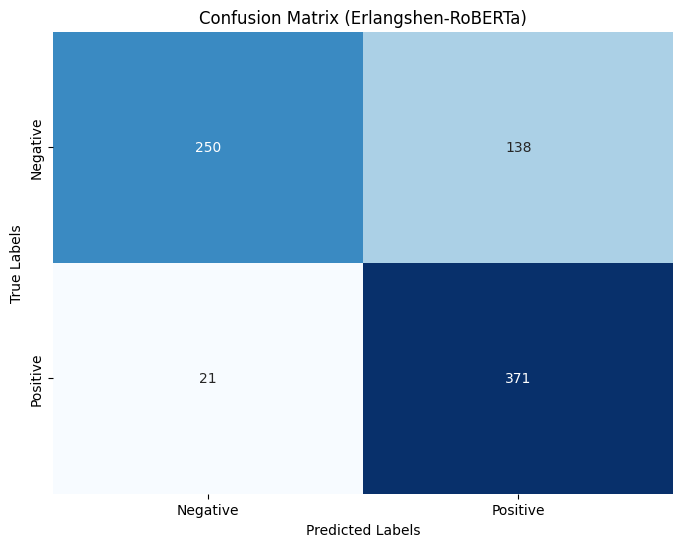

In [28]:
# Plot the confusion matrix as a heatmap

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the confusion matrix
conf_matrix = confusion_matrix(labels, all_predictions)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Erlangshen-RoBERTa)")
plt.show()

# Erlangshen-RoBERTa-110M-Sentiment (Fine-tuned with Code-switched Data)

In [29]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_name = "IDEA-CCNL/Erlangshen-RoBERTa-110M-Sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name, src_lang="yue_Hant")
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [30]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=512)

# Tokenize the dataset
filtered_dataset = cs_dataset.filter(lambda example: example['label'] in [0, 2]).map(
    lambda example: {'label': 1 if example['label'] == 2 else example['label']}
)

tokenized_dataset = filtered_dataset.map(preprocess_function, batched=True)


Filter:   0%|          | 0/1154 [00:00<?, ? examples/s]

Map:   0%|          | 0/780 [00:00<?, ? examples/s]

Map:   0%|          | 0/780 [00:00<?, ? examples/s]

In [31]:
from torch.utils.data import DataLoader

# Convert the tokenized test dataset to PyTorch tensors
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Create a DataLoader for the test dataset
test_dataloader = DataLoader(tokenized_dataset, batch_size=16)

In [32]:
train_test_split = tokenized_dataset.train_test_split(test_size=0.2, stratify_by_column='label', seed=42)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

In [33]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Ensure predictions are converted from logits to class indices
    if isinstance(predictions, tuple):
        predictions = predictions[0]  # Extract logits


    predictions = predictions.argmax(axis=1)  # Get predicted class index
    labels = labels.astype(int)

    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}

In [34]:
# Define the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,  # Enable mixed precision training for faster training
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Fine-tune the model
trainer.train()

# Save the fine-tuned model
trainer.save_model("./fine_tuned_Erlangshen-cs")
tokenizer.save_pretrained("./fine_tuned_Erlangshen-cs")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-34-a51c51092174>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.172053,0.967949
2,No log,0.173434,0.961538
3,No log,0.257022,0.955128


('./fine_tuned_Erlangshen-cs/tokenizer_config.json',
 './fine_tuned_Erlangshen-cs/special_tokens_map.json',
 './fine_tuned_Erlangshen-cs/vocab.txt',
 './fine_tuned_Erlangshen-cs/added_tokens.json',
 './fine_tuned_Erlangshen-cs/tokenizer.json')

In [35]:
# Step 1: Perform prediction
prediction_output = trainer.predict(test_dataset)

# Step 2: Access predictions and true labels
predictions = prediction_output.predictions
labels = prediction_output.label_ids

In [36]:
# Step 5: Convert logits to class predictions if necessary
if len(predictions.shape) == 2:  # Assuming logits are 2-dimensional
    predictions = np.argmax(predictions, axis=1)

# Step 6: Verify shapes
print("Labels shape:", labels.shape)
print("Predictions shape:", predictions.shape)

# Step 7: Compute metrics
accuracy = accuracy_score(labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(
    labels, predictions, average='weighted'
)

# Step 8: Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the classification report
report = classification_report(labels, predictions, target_names=["Negative", "Positive"])

# Print the classification report
print(report)


Labels shape: (156,)
Predictions shape: (156,)
Accuracy: 0.967948717948718
Precision: 0.9680256452408352
Recall: 0.967948717948718
F1-score: 0.9679474008629546
              precision    recall  f1-score   support

    Negative       0.96      0.97      0.97        78
    Positive       0.97      0.96      0.97        78

    accuracy                           0.97       156
   macro avg       0.97      0.97      0.97       156
weighted avg       0.97      0.97      0.97       156



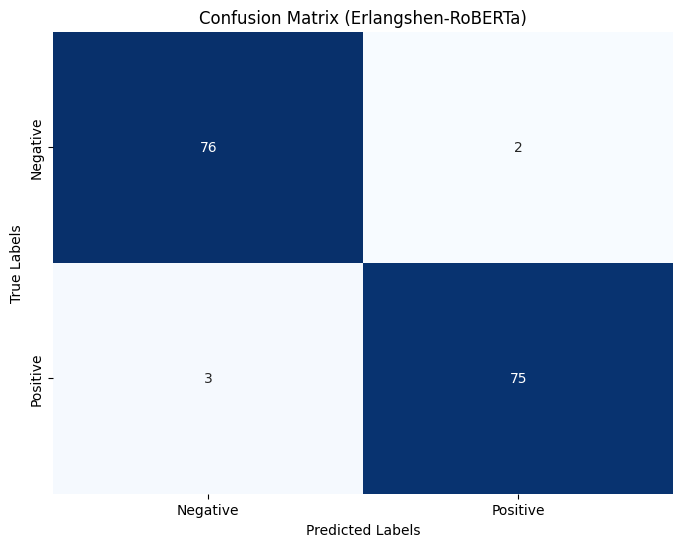

In [37]:
# Plot the confusion matrix as a heatmap

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the confusion matrix
conf_matrix = confusion_matrix(labels, predictions)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Erlangshen-RoBERTa)")
plt.show()

# Erlangshen-RoBERTa-110M-Sentiment (Fine-tuned with Monolingual Data)

In [38]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_name = "IDEA-CCNL/Erlangshen-RoBERTa-110M-Sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name, src_lang="yue_Hant")
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [39]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=512)

train_dataset = canto_dataset.shuffle(seed=42).select(range(15000))
test_dataset = cs_dataset

filtered_train_dataset = train_dataset.filter(lambda example: example['label'] in [0, 2]).map(
    lambda example: {'label': 1 if example['label'] == 2 else example['label']}
)

filtered_test_dataset = test_dataset.filter(lambda example: example['label'] in [0, 2]).map(
    lambda example: {'label': 1 if example['label'] == 2 else example['label']}
)

print(filtered_train_dataset)
print(filtered_test_dataset)

Filter:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10823 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1154 [00:00<?, ? examples/s]

Map:   0%|          | 0/780 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label'],
    num_rows: 10823
})
Dataset({
    features: ['text', 'label'],
    num_rows: 780
})


In [40]:
tokenized_train_dataset = filtered_train_dataset.map(preprocess_function, batched=True)
tokenized_test_dataset = filtered_test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/10823 [00:00<?, ? examples/s]

Map:   0%|          | 0/780 [00:00<?, ? examples/s]

In [41]:
from torch.utils.data import DataLoader

# Convert the tokenized test dataset to PyTorch tensors
tokenized_train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

tokenized_train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])


In [42]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Ensure predictions are converted from logits to class indices
    if isinstance(predictions, tuple):
        predictions = predictions[0]  # Extract logits


    predictions = predictions.argmax(axis=1)  # Get predicted class index
    labels = labels.astype(int)

    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,  # Enable mixed precision training for faster training
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Fine-tune the model
trainer.train()

# Save the fine-tuned model
trainer.save_model("./fine_tuned_Erlangshen")
tokenizer.save_pretrained("./fine_tuned_Erlangshen")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-43-f02eb8d14616>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.166400,0.708080,0.761538
2,0.107500,0.776885,0.776923
3,0.037800,0.712368,0.819231


('./fine_tuned_Erlangshen/tokenizer_config.json',
 './fine_tuned_Erlangshen/special_tokens_map.json',
 './fine_tuned_Erlangshen/vocab.txt',
 './fine_tuned_Erlangshen/added_tokens.json',
 './fine_tuned_Erlangshen/tokenizer.json')

In [44]:
# Step 1: Perform prediction
prediction_output = trainer.predict(tokenized_test_dataset)

# Step 2: Access predictions and true labels
predictions = prediction_output.predictions
labels = prediction_output.label_ids

In [45]:
# Step 5: Convert logits to class predictions if necessary
if len(predictions.shape) == 2:  # Assuming logits are 2-dimensional
    predictions = np.argmax(predictions, axis=1)

# Step 6: Verify shapes
print("Labels shape:", labels.shape)
print("Predictions shape:", predictions.shape)

# Step 7: Compute metrics
accuracy = accuracy_score(labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(
    labels, predictions, average='weighted'
)

# Step 8: Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the classification report
report = classification_report(labels, predictions, target_names=["Negative", "Positive"])

# Print the classification report
print(report)


Labels shape: (780,)
Predictions shape: (780,)
Accuracy: 0.8192307692307692
Precision: 0.8639826617624312
Recall: 0.8192307692307692
F1-score: 0.8132973682177702
              precision    recall  f1-score   support

    Negative       0.99      0.64      0.78       388
    Positive       0.74      0.99      0.85       392

    accuracy                           0.82       780
   macro avg       0.86      0.82      0.81       780
weighted avg       0.86      0.82      0.81       780



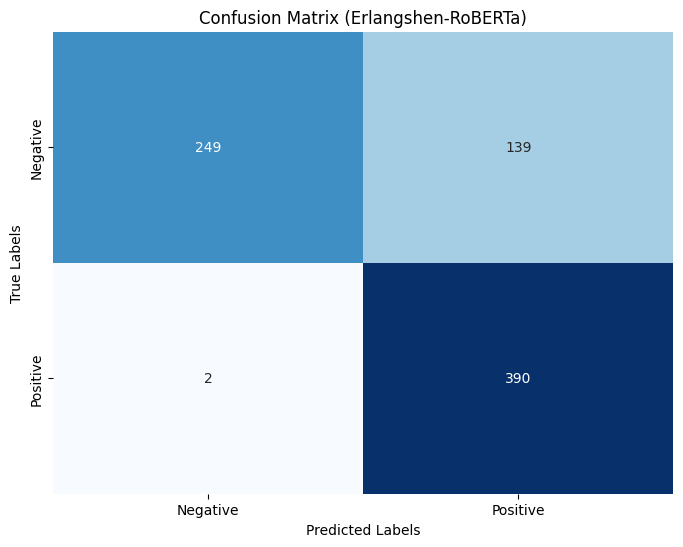

In [46]:
# Plot the confusion matrix as a heatmap

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the confusion matrix
conf_matrix = confusion_matrix(labels, predictions)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Erlangshen-RoBERTa)")
plt.show()